In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# TypedDict: 항상들어감, Annotated: list가 어떤 행동을 할수 있는지에 대한 metadata추가.
from typing import TypedDict, Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import operator

In [3]:
# 그래프 정의
class State(TypedDict):
    #counter: int
    messages: Annotated[list, add_messages] # list를 업데이트할 때 add_messages를 통해 누적해서 메세지를 쌓아나간다.
    # messages: Annotated[list[str], operator.add]

graph_builder = StateGraph(State)

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

# 노드정의
def node_a(state:State):
    #state["counter"] = state.get("counter", 0) + 1
    return {
        "messages" : [llm.invoke(state["messages"])],
        #"counter": state["counter"]
    }

# 노드
graph_builder.add_node("chatbot", node_a)

# 엣지
graph_builder.add_edge(START, "chatbot") # graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("chatbot", END) # graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()


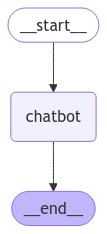

In [4]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
# 메모리 저장기능이 없다.
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values(): #event안에는 state가 있다.
            print("User input: ", user_input)
            print("Assistant: ", value["messages"][-1].content) # 가장 최신의 content를 assistant에 넣고 print하겠다.

User input:  안녕
Assistant:  안녕하세요! 어떻게 도와드릴까요?
User input:  내 이름은 재호야
Assistant:  안녕하세요, 재호님! 어떻게 도와드릴까요?
User input:  내 이름이 뭐라고?
Assistant:  죄송하지만, 당신의 이름을 알 수 있는 정보가 없습니다. 당신의 이름을 알려주시면 좋겠어요!
User input:  
Assistant:  Hello! How can I assist you today?
Goodbye!


In [6]:
from typing import Annotated # 알파벳이라는 특성을 업데이트. Annotated를 통해서 list가 어떤 행동을 할수 있는지에 대해서 metadata를 추가. 
from langchain_openai import ChatOpenAI

from typing import TypedDict

from langgraph.graph import StateGraph 
from langgraph.graph.message import add_messages

class State(TypedDict):
    counter: int
    messages: Annotated[list, add_messages] # list를 업데이트할때, add_messages를 통해 누적해서 메세지를 쌓아나간다.

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

# 입력값은 State 출력값은 "messages"라는 키값에 llm이 주어진 messages를 입력해서 invoke한 실행 결과다.
def node_b(state: State):
    state["counter"] = state.get("counter", 0) + 1 #counter값이 없으면0, 아니면 있는값에 +1
    return {
        "messages" : [llm.invoke(state["messages"])],
        "counter": state["counter"]
    }

# add_edge(START, "chatbot"), add_edge('chatbot', END)와 같음

graph_builder.add_node("node_b", node_b)
graph_builder.set_entry_point("node_b")
graph_builder.set_finish_point("node_b")
graph = graph_builder.compile()

In [7]:
from langchain_core.messages import HumanMessage
# 초기상태 정의
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "counter" : 0
}

# 그래프 실행
result = graph.invoke(initial_state)

print(f"Final state: {result}")

Final state: {'counter': 1, 'messages': [HumanMessage(content='Hello!', id='f421a242-272f-49e8-962a-ca9a4ff9f8af'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-872b1081-240f-4473-991d-2aa84e9aa666-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})]}


In [8]:
state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(f"counter: {state['counter']}")
    print(f"Last message: {state['messages'][-1].content}")
    print("---")

counter: 1
Last message: Hello! How can I assist you today?
---
counter: 2
Last message: Hello! How can I assist you today?
---
counter: 3
Last message: Hello! How can I assist you today?
---


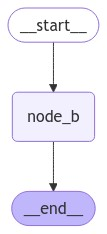

In [9]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass